In [1]:

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

from scripts.plotting_functions import myHeatmap, confidence_ellipse
from scripts.preprocessor_functions import remove_vignette, calculate_background_color

import time
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import json

In [2]:
SET_DIR = r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene"

SET_NAMES = [
    "Set_1",
    # "Set_2",
    # "Set_3",
    # "Set_4",
    "Set_5",
    "Set_6",
    "Set_7",
]

PARAM_DIR = r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotation_Tool\Parameters"
PLOT_SAVE_DIR = "Plots_Together"

if not os.path.exists(PLOT_SAVE_DIR):
    os.mkdir(PLOT_SAVE_DIR)

COMPONENT_COLORS = cm.get_cmap("tab10")(np.linspace(0, 1, 10))

SET_NAMES = np.array(SET_NAMES)	

COLOR_NAMES = ["Blue", "Green", "Red"]

In [3]:
# saves a tuple of the image name, the mask , the label and the thickness of each flake
IMAGE_MASK_LABEL_THICKNESS_ARRAY = []

FF_PATHS = []

for i in range(len(SET_NAMES)):

    SET_PATH = os.path.join(SET_DIR, SET_NAMES[i])

    FF_PATHS.append(os.path.join(SET_PATH, "flatfield.png"))

    # extract all the mask directorys
    MASK_DIRS = [
        directory
        for directory in os.listdir(SET_PATH)
        if directory.startswith("Masks_") and directory != "Masks_Human_Annotated"
    ]

    for mask_dir in MASK_DIRS:
        thickness = int(mask_dir.split("_")[1])
        MASK_DIR_PATH = os.path.join(SET_PATH, mask_dir)
        MASK_NAMES = [
            file for file in os.listdir(MASK_DIR_PATH) if file.endswith(".png")
        ]
        for mask_name in MASK_NAMES:
            mask_path = os.path.join(MASK_DIR_PATH, mask_name)
            image_name = mask_name.split("_")[2]
            image_path = os.path.join(SET_PATH, "Images", image_name)
            IMAGE_MASK_LABEL_THICKNESS_ARRAY.append(
                (image_path, mask_path, i, thickness)
            )


In [5]:
full_colors = []
full_contrasts = []
labels = []
thicknesses = []
background_colors = []
background_labels = []

flatfields = [cv2.imread(path) for path in FF_PATHS]

start = time.time()

for idx, flake in enumerate(IMAGE_MASK_LABEL_THICKNESS_ARRAY):

    if idx % 100 == 0:
        seconds = time.time() - start
        print(
            f"\r{idx}/{len(IMAGE_MASK_LABEL_THICKNESS_ARRAY)} scanned | Time taken : ~ {seconds // 3600:02.0f}:{(seconds // 60 )% 60:02.0f}:{int(seconds) % 60:02.0f}\r",
            end="",
            flush=True,
        )

    image_path, mask_path, label, thickness = flake

    mask = cv2.imread(mask_path, 0)
    mask = cv2.erode(mask, np.ones((3, 3)), iterations=2)

    if cv2.countNonZero(mask) < 100:
        continue

    image = cv2.imread(image_path)
    image = remove_vignette(image, flatfields[label])

    flake_color = np.array(image[mask == 255])

    # extracting the contrast of the flake
    background_color = np.array(calculate_background_color(image))

    if np.any(background_color == 0):
        print(image_path)
        continue

    contrasted_image = (image / background_color) - 1
    flake_contrast = np.array(contrasted_image[mask == 255])

    full_colors.extend(flake_color)
    full_contrasts.extend(flake_contrast)
    labels.extend([label] * len(flake_contrast))
    thicknesses.extend([thickness] * len(flake_contrast))
    
    background_colors.append(background_color)
    background_labels.append(label)

full_colors = np.array(full_colors)
background_colors = np.array(background_colors)
full_contrasts = np.array(full_contrasts)
thicknesses = np.array(thicknesses)
background_labels = np.array(background_labels)
labels = np.array(labels)

print("")
print(len(full_contrasts))
print(len(background_colors))
print(np.unique(labels, return_counts=True))


C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set_7\Images\7a338354-38f9-4011-b635-3721c289930e.png
C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set_7\Images\f6e034d9-c776-44f8-b0bb-b2393faf01d3.png
1200/1212 scanned | Time taken : ~ 00:04:25
1687276
1186
(array([0, 1, 2, 3]), array([634707, 106130, 446235, 500204], dtype=int64))


In [6]:
# cropping the contrast array
#lower_bounds = [-0.4, -0.6, -0.6]  # B,G,R
lower_bounds = [-0.6, -0.7, -0.7]  # B,G,R
upper_bounds = [0, 0, 0]  # B,G,R

labels_cropped = labels[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]
thicknesses_cropped = thicknesses[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]

full_contrasts_cropped = full_contrasts[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]


print(len(full_contrasts_cropped))


1686864


## Sample the Thicknesses as well as the Sets

In [8]:
sampled_labels = []
sampled_thicknesses = []
sampled_contrasts = []

unique_labels , label_counts = np.unique(labels_cropped, return_counts=True)
print(unique_labels,label_counts)
# this is the number of samples we want to take from each label
min_count_labels = np.min(label_counts)

for unique_label in unique_labels:
    label_indices = np.where(labels_cropped == unique_label)[0]
    label_indices = np.random.choice(label_indices, min_count_labels, replace=False)
    sampled_labels.extend([unique_label] * min_count_labels)
    sampled_thicknesses.extend(thicknesses_cropped[label_indices])
    sampled_contrasts.extend(full_contrasts_cropped[label_indices])

sampled_contrasts = np.array(sampled_contrasts)
sampled_labels = np.array(sampled_labels)
sampled_thicknesses = np.array(sampled_thicknesses)

[0 1 2 3] [634702 106105 446182 499875]


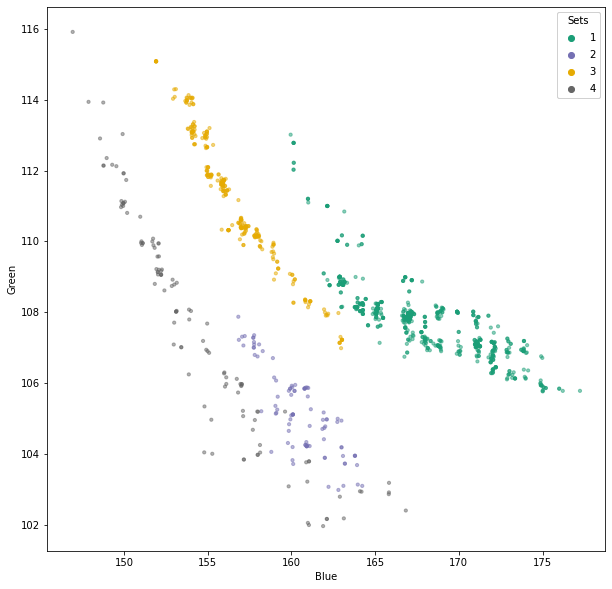

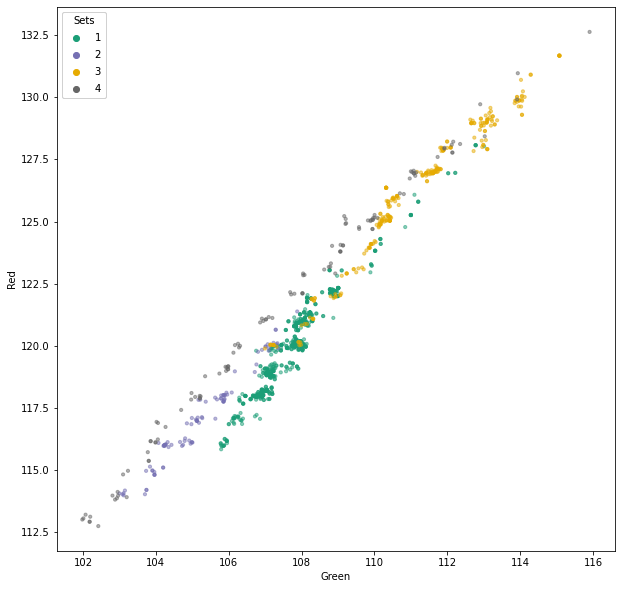

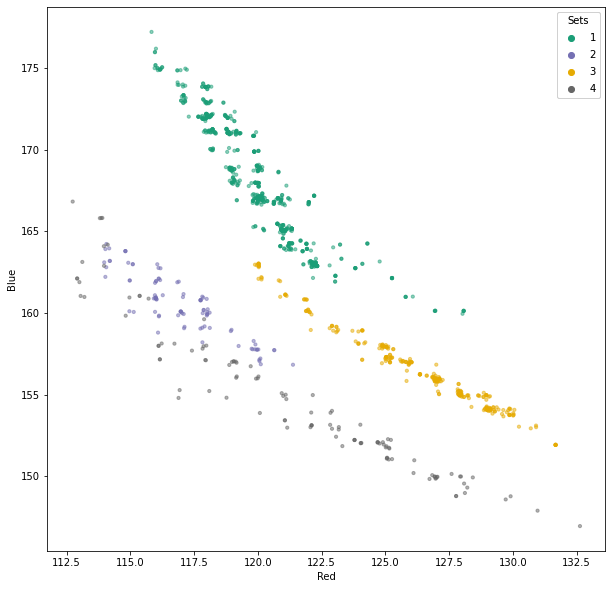

In [9]:
# Plotting the background colors

for i in range(3):

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    scatter = ax.scatter(
        background_colors[:, i],
        background_colors[:, (i + 1) % 3],
        c=background_labels + 1,
        cmap="Dark2",
        s=10,
        alpha=0.5,
    )
    
    add_legend(ax, scatter, title="Sets")

    ax.set_xlabel(COLOR_NAMES[i])
    ax.set_ylabel(COLOR_NAMES[(i + 1) % 3])
    plt.show()


In [21]:
with open(f"{PARAM_DIR}/new_graphene.json", "r") as f:
    component_dict = json.load(f)

prev_means = []
prev_covs = []

for component in component_dict:
    contrasts = [
        component_dict[component]["contrast"]["b"],
        component_dict[component]["contrast"]["g"],
        component_dict[component]["contrast"]["r"],
    ]
    cov = component_dict[component]["covariance_matrix"]
    prev_means.append(contrasts)
    prev_covs.append(cov)

prev_means = np.array(prev_means)
prev_covs = np.array(prev_covs)

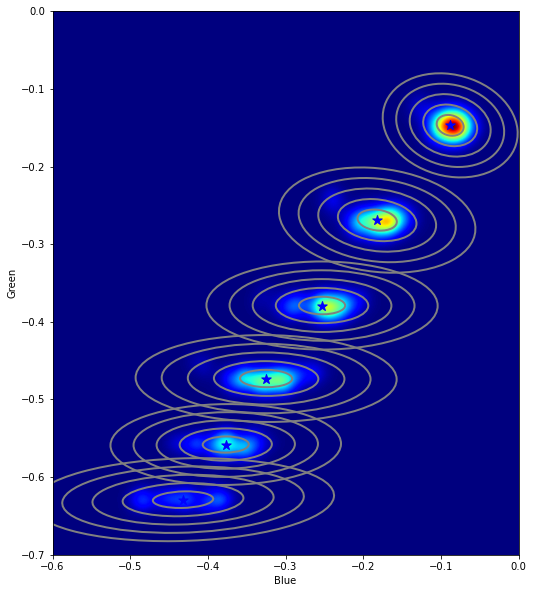

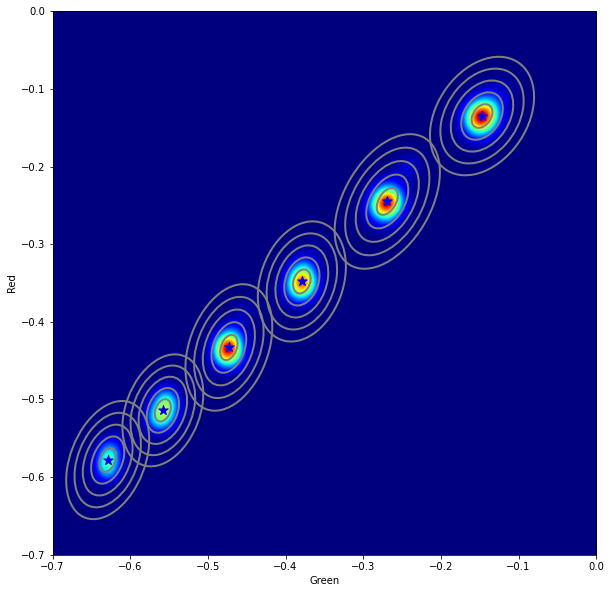

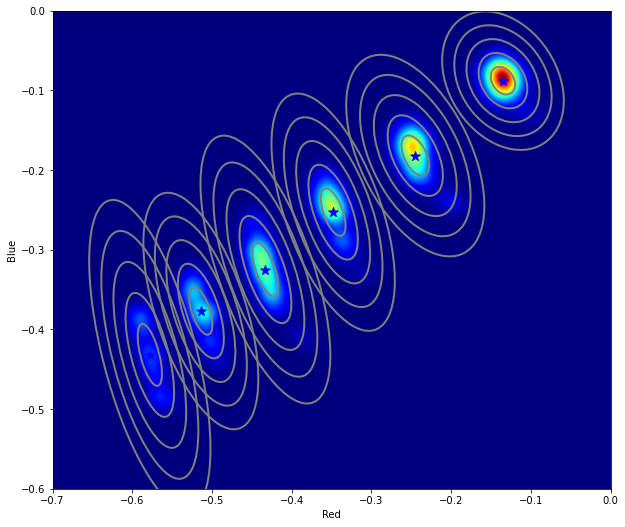

In [22]:
for i in [0, 1, 2]:

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    X_DATA = sampled_contrasts[:, [i, (i + 1) % 3]]
    gauss_means = prev_means[:, [i, (i + 1) % 3]]
    covariances = prev_covs[:, :, [i, (i + 1) % 3]][:, [i, (i + 1) % 3], :]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    img, extent = myHeatmap(
        X_DATA[:, 0],
        X_DATA[:, 1],
        10,
        bins=1000,
        extent=[x_lower, x_upper, y_lower, y_upper],
    )
    plt.imshow(img, extent=extent, origin="lower", cmap=cm.jet)

    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])

    # add the confidence ellipse
    for j in range(len(prev_means)):
        for h in range(5):
            confidence_ellipse(
                ax,
                mean=gauss_means[j],
                cov=covariances[j],
                n_std=h + 1,
                facecolor="none",
                edgecolor="grey",
            )

    plt.scatter(gauss_means[:, 0], gauss_means[:, 1], s=100, marker="*", c="b")

    # plt.legend()
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])
    plt.savefig(
        f"{PLOT_SAVE_DIR}/HEAT_{COLOR_NAMES[i]}_{COLOR_NAMES[(i + 1) % 3]}.jpg", dpi=500
    )
    plt.show()


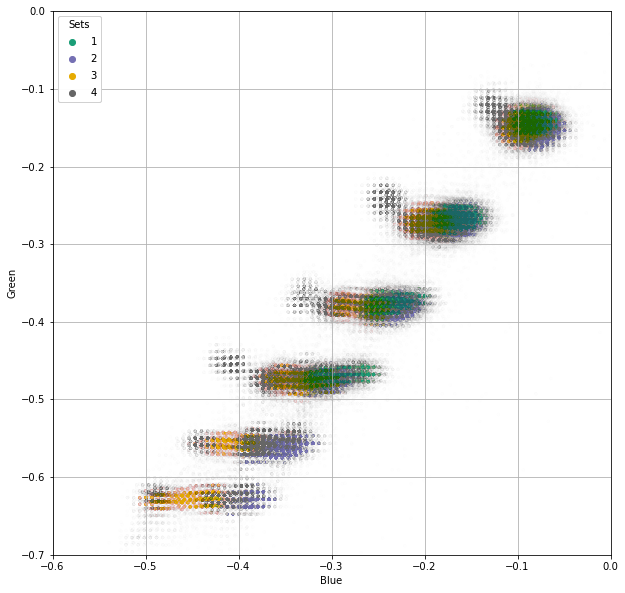

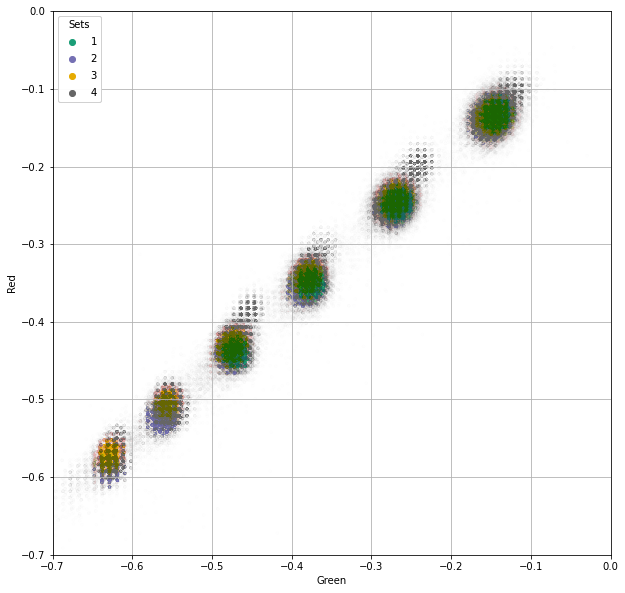

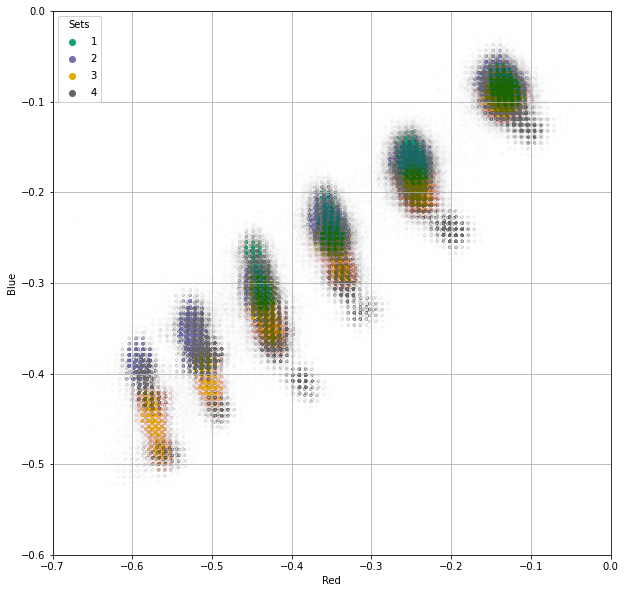

In [12]:
for i in range(3):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    gauss_means = prev_means[:, [i, (i + 1) % 3]]
    covariances = prev_covs[:, :, [i, (i + 1) % 3]][:, [i, (i + 1) % 3], :]
    X_DATA = sampled_contrasts[:, [i, (i + 1) % 3]]

    # increast the font size
    # plt.rcParams.update({'font.size': 20})

    scatter = ax.scatter(
        X_DATA[:, 0],
        X_DATA[:, 1],
        s=10,
        alpha=0.004,
        c=sampled_labels + 1,
        cmap="Dark2",
    )

    add_legend(ax, scatter, title="Sets")

    # for j in range(len(prev_means)):
    #     for h in range(3):
    #         confidence_ellipse(
    #             ax,
    #             mean=gauss_means[j],
    #             cov=covariances[j],
    #             n_std=h + 1,
    #             facecolor="none",
    #             edgecolor="grey",
    #         )

    ax.set_xlabel(COLOR_NAMES[i])
    ax.set_ylabel(COLOR_NAMES[(i + 1) % 3])
    ax.grid()
    ax.set_xlim(x_lower, x_upper)
    ax.set_ylim(y_lower, y_upper)
    plt.savefig(f"{PLOT_SAVE_DIR}/compared_scatter_contrast_{i}.jpg", dpi=300)
    plt.show()


In [15]:
NUM_COMPONENTS = 6
USE_ADDITIONAL_COMPONENT_FOR_NOISE = False
COV_TYPE = "full"

if USE_ADDITIONAL_COMPONENT_FOR_NOISE:
    NUM_COMPONENTS += 1

# Used to scale on of the dimensions of the ellipse
# In this case the Blue Channel
SCALING_MATRIX = np.diag([1,1,1])

kmeans = KMeans(n_clusters=NUM_COMPONENTS, random_state=0)
kmeans.fit(sampled_contrasts)
all_means_kmeans = kmeans.cluster_centers_

gaussian_model = GaussianMixture(
    n_components=NUM_COMPONENTS,
    covariance_type=COV_TYPE,
    max_iter=100,
    init_params="kmeans",
    means_init=all_means_kmeans,
    n_init=10,
    tol=1e-4,
    reg_covar=1e-7,
    warm_start=False,
)

gaussian_model.fit(sampled_contrasts)

all_means_gauss = np.round(gaussian_model.means_, 3)
predicted_labels = gaussian_model.predict(sampled_contrasts)

if COV_TYPE == "tied":
    all_covariances_gauss = np.array([gaussian_model.covariances_] * NUM_COMPONENTS)
else:
    all_covariances_gauss = gaussian_model.covariances_

# scale the covariance matrix
for i in range(NUM_COMPONENTS):
    all_covariances_gauss[i] = (
        SCALING_MATRIX.T @ all_covariances_gauss[i] @ SCALING_MATRIX
    )

# Remove the additional component for noise if we used it
# It has the largest eigenvalue by default as its ellipse is the biggest
if USE_ADDITIONAL_COMPONENT_FOR_NOISE:
    max_ev = 0
    max_ev_idx = 0
    # get the eigenvalues and eigenvectors
    for idx, cov in enumerate(all_covariances_gauss):
        eig_vals, _ = np.linalg.eig(cov)
        if np.sum(eig_vals) > max_ev:
            max_ev = np.sum(eig_vals)
            max_ev_idx = idx

    # remove the largest eigenvalue
    all_covariances_gauss = np.delete(all_covariances_gauss, max_ev_idx, axis=0)
    all_means_gauss = np.delete(all_means_gauss, max_ev_idx, axis=0)
    all_means_kmeans = np.delete(all_means_kmeans, max_ev_idx, axis=0)


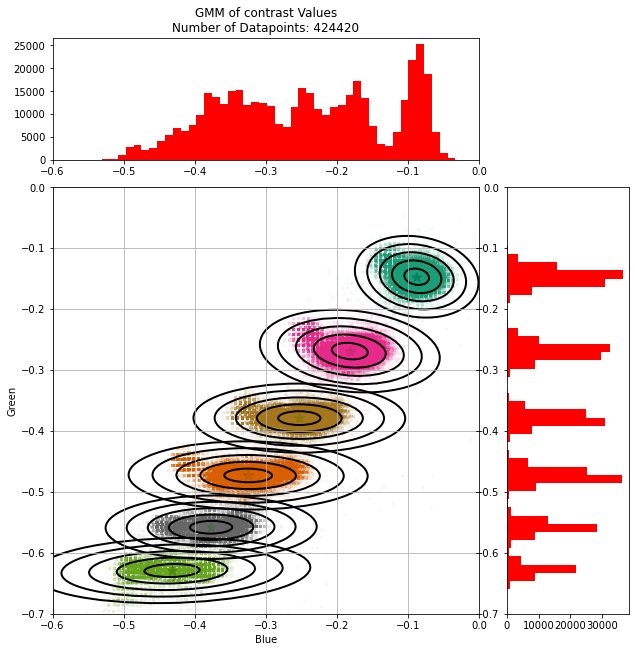

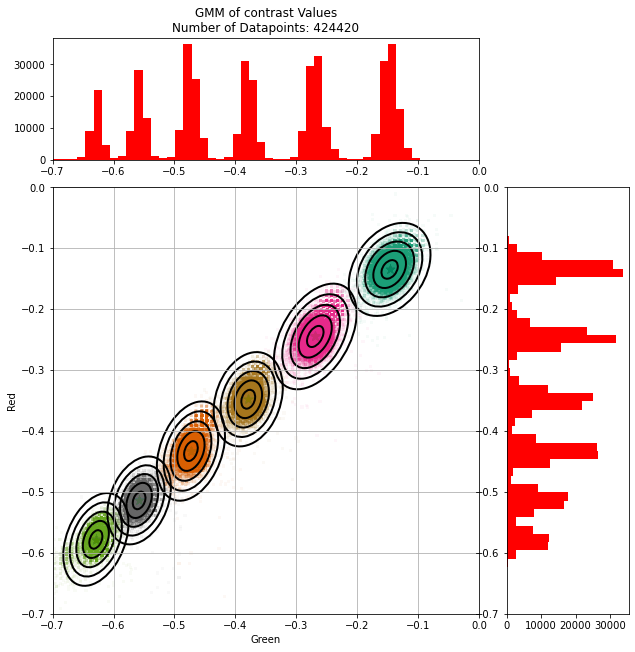

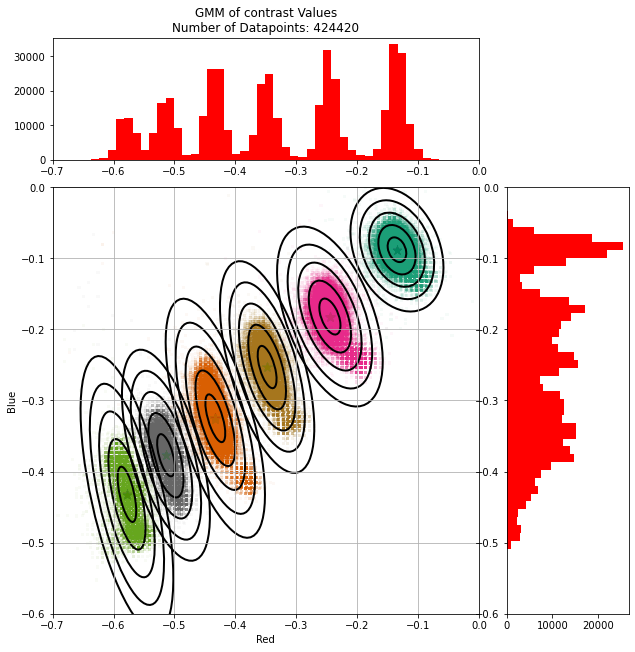

In [16]:
NUM_BINS = 50

for i in [0, 1, 2]:

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    X_DATA = sampled_contrasts[:, [i, (i + 1) % 3]]
    gauss_means = all_means_gauss[:, [i, (i + 1) % 3]]
    km_means = all_means_kmeans[:, [i, (i + 1) % 3]]
    covariances = all_covariances_gauss[:, :, [i, (i + 1) % 3]][:, [i, (i + 1) % 3], :]

    fig = plt.figure(figsize=(10, 10))

    # Define the plot windows
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(7, 2),
        height_ratios=(2, 7),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.1,
        hspace=0.1,
    )

    # add subplots for the data
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # add the histograms
    if NUM_BINS == 0:
        bins_x = np.linspace(x_lower, x_upper, x_upper - x_lower + 1) - 0.5
        bins_y = np.linspace(y_lower, y_upper, y_upper - y_lower + 1) - 0.5
    else:
        bins_x = NUM_BINS
        bins_y = NUM_BINS
    ax_histx.hist(X_DATA[:, 0], bins=bins_x, color="r")
    ax_histy.hist(X_DATA[:, 1], bins=bins_y, orientation="horizontal", color="r")

    # add the confidence ellipse
    for j in range(gauss_means.shape[0]):
        
        ax.scatter(gauss_means[j, 0], gauss_means[j, 1], s=100, marker="*", c="b")
        ax.scatter(km_means[j, 0], km_means[j, 1], s=100, marker="*", c="g")

        for h in range(5):
            confidence_ellipse(
                ax,
                mean=gauss_means[j],
                cov=covariances[j],
                n_std=h + 1,
                facecolor="none",
                edgecolor="black",
            )

    ax.scatter(
        X_DATA[:, 0],
        X_DATA[:, 1],
        s=10,
        marker="s",
        alpha=0.04,
        ec="None",
        c=predicted_labels,
        cmap = "Dark2",
    )

    # ax.legend()
    ax.set_xlim(x_lower, x_upper)
    ax.set_ylim(y_lower, y_upper)
    ax.set_xlabel(COLOR_NAMES[i])
    ax.set_ylabel(COLOR_NAMES[(i + 1) % 3])
    ax.grid()
    ax_histx.set_title(
        f"GMM of contrast Values\nNumber of Datapoints: {X_DATA.shape[0]}"
    )
    plt.savefig(
        f"{PLOT_SAVE_DIR}/{COLOR_NAMES[i]}_{COLOR_NAMES[(i + 1) % 3]}.jpg", dpi=500
    )
    plt.show()


In [17]:
component_dict = {}

for component in range(all_means_gauss.shape[0]):
    component_dict[component] = {}
    component_dict[component]["contrast"] = {
        "r": all_means_gauss[component][2],
        "g": all_means_gauss[component][1],
        "b": all_means_gauss[component][0],
    }
    component_dict[component]["covariance_matrix"] = all_covariances_gauss[
        component
    ].tolist()
    component_dict[component]["color_radius"] = {
        "r": 0.06,
        "g": 0.06,
        "b": 0.1,
    }

with open("gaussian_mixture_model_contrast_data_MULTISET.json", "w") as f:
    json.dump(component_dict, f)
